This is a simple example showing how to use this package to train a machine learning force field using your data.

In this example, we will study a system of two helium atoms interacting through a Lennard-Jones potential. The example is divided into two main sections:

1) Model Setup and Training:
    We will load a pre-generated dataset containing configurations of two helium atoms in a simulation box and use the SymmLearn functions to build and train our neural network model.

2) Results and Comparison:
    Finally, we will analyze the results. For this simple case, it is possible to visualize the trained force field and compare it to the reference Lennard-Jones potential.


In [7]:
#using Symmlearn
using Plots

include("../src/Train.jl")
include("../src/Model.jl")
include("../src/Data_prep.jl")
include("../src/Utils.jl")

extract_forces

The loading process of the .xyz dataset con be done as illustrated here in the next code block.

Everything is fuly explained in the documentation, it's important to mention that the target data is stored in a Vector of Sample structs, containing both the sample energy and the forces

This dataset consists in 500 samples,for each of them the energy was computed using a Lennard-Jones potential with $\sigma$ = 1 and $\epsilon$ = 1.

For each sample the distance between the two Helium atoms was randomly generated between 0.95 $\sigma$ and 2.5 $\sigma$




In [8]:
file_path = "helium_LJ_dataset.xyz"

Train, Val, Test_data, energy_mean, energy_std, forces_mean, forces_std, species, all_cells = xyz_to_nn_input(file_path)





((Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Sample[Sample(-1.6011864f0, Float32[0.52123755 0.0 … 0.0 0.0]), Sample(0.4680886f0, Float32[0.31671304 0.0 … 0.0 0.0]), Sample(-1.399849f0, Float32[0.5364677 0.0 … 0.0 0.0]), Sample(-1.860274f0, Float32[0.22971028 0.0 … 0.0 0.0]), Sample(0.4352567f0, Float32[0.32062662 0.0 … 0.0 0.0]), Sample(0.44202372f0, Float32[0.31979877 0.0 … 0.0 0.0]), Sample(0.2686634f0, Float32[0.34315154 0.0 … 0.0 0.0]), Sample(0.42320356f0, Float32[0.32212886 0.0 … 0.0 0.0]), Sample(-1.4770622f0, Float32[0.53379023 0.0 … 0.0 0.0]), Sample(4.941946f0, Float32[-5.059343 0.0 … 0.0 0.0])  …  Sample(-0.21634339f0, Float32[0.41587153 0.0 … 0.0 0.0]), Sample(-0.16515031f0, Float32[0.40815267 0.0 … 0.0 0.0]), Sample(-0.6218223f0, Float32[0.47395906 0.0 … 0.0 0.0]), Sample(0.26896632f0, Float32[0.34310868 0.0 … 0.0 0.0]), Sample(-1.7988881f0, Float32[0.096798226 0.0 … 0.0 0.0]), Sample(0.4081947f0, Float32[0.3240394 0.0 … 0.0 0.

The xyz_to_nn_input function returns the data already split in test, train and validation, the mean and the standard deviation of both the energies and the forces in order to renormalize them later and the lattice parameters, used by the model to compute the atomic distances with periodic boundary conditions ( in this example we won't be using PBC as the helium atoms are confined in a box )

In the next block we wil building and check if our model behaves as expected,  since the system is trivial using the forces to train it won't be needed

In [ ]:
#define the model using 5 G1 symmetry functions


model = build_model(species, 5, 2.5f0)

#We can check if the model and the loss work as we expected on a small batch 

x_batch = Train[1][1:3, :]
y_batch = Train[2][1:3]

e = extract_energies(y_batch)
f = 0f0 # we won't need to train the model using the forces



println("Model output with a batch as input: ", model(x_batch))
println("Model loss with batch input: ", loss(model, x_batch, e , f))




Float32[0.0 0.0 0.0 1.202145 0.0 0.0; 0.0 0.0 0.0 2.377267 0.0 0.0; 0.0 0.0 0.0 1.238136 0.0 0.0]
Model output with a batch as input: Float32[0.6401378, 8.047445f-5, 0.6338459]
Model loss with batch input: 23.116331


And now we can train it

In [11]:
#we train the model setting the parameter forces to false

last_model, best_model, train_loss, val_loss = train_model!(
        model,
        Train[1], 
        Train[2], 
        Val[1],
        Val[2],
        loss;
         forces = false , initial_lr=0.1, epochs=1000, batch_size=32 , verbose=false
    )

LoadError: Function argument passed to autodiff cannot be proven readonly.
If the the function argument cannot contain derivative data, instead call autodiff(Mode, Const(f), ...)
See https://enzyme.mit.edu/index.fcgi/julia/stable/faq/#Activity-of-temporary-storage for more information.
The potentially writing call is   store {} addrspace(10)* %.fca.1.0.extract, {} addrspace(10)* addrspace(10)* %memcpy_refined_dst.i, align 8, !dbg !23, !tbaa !43, !alias.scope !29, !noalias !45, using   %.fca.1.0.extract = extractvalue { {} addrspace(10)*, [1 x {} addrspace(10)*], {} addrspace(10)* } %0, 1, 0, !dbg !8, !enzyme_type !12, !enzymejl_byref_MUT_REF !0, !enzymejl_source_type_Vector\7BFloat32\7D !0


Now our model has been trained, we can look at the results, the plot compares the energy of each pair as a function of the distance between the two atoms with the LJ potential for the test set

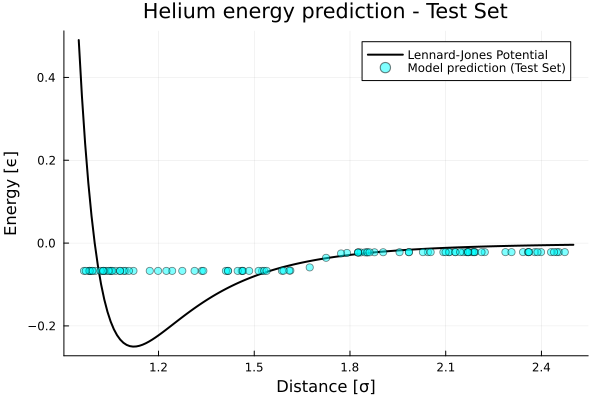

In [ ]:
# Denormalize model predictions for the test set using Z-score inversion
test_guess = best_model(Test_data[1])' .* energy_std .+ energy_mean

# Extract interatomic distances from the test set (for plotting)
test_distances = [Test_data[1][i, 4] for i in 1:size(Test_data[1], 1)]


# Define Lennard-Jones potential curve for reference
r = 0.95:0.01:2.5
lj_energy =  ((1 ./ r).^12 .- (1 ./ r).^6)

plot(r, lj_energy,
    label="Lennard-Jones Potential",
    color="black",
    lw=2
)

# Plot predictions vs Lennard-Jones potential
scatter!(test_distances, test_guess,
    label="Model prediction (Test Set)",
    alpha=0.5,
    color="cyan"
)



xlabel!("Distance [σ]")
ylabel!("Energy [ϵ]")
title!("Helium energy prediction - Test Set")


As expected the model managed to reproduce very well the Lennard Jones potential